In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy
import time
import os
import random
import warnings
import statistics as st

In [2]:
### joint-normal distribution that produce joint normally distribution that has 0.16 correlation between Income and Ability

mean = [15.90,5.95562152119475]
cov= [[2.3**2,1.5188814132043555], [1.5188814132043555,(4.127395144577053)**2]]
n = 1000
np.random.seed(n)
b,y = np.random.multivariate_normal(mean, cov, n).T
x1 = b,y

x1 = pd.DataFrame(x1).T
x1 = x1.rename(columns={0: 'Ability', 1: 'Income'})

x1['Ability'] = x1['Ability'].apply(lambda x:x if x>0 else 0)
x1['Income'] = x1['Income'].apply(lambda x:x if x>0 else 0)

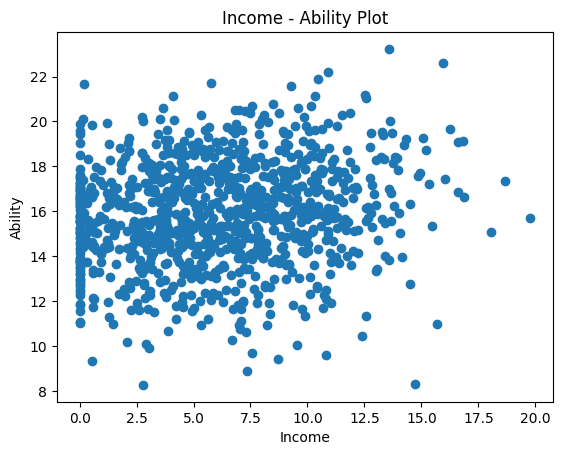

In [3]:
plt.scatter(x1['Income'], x1['Ability'])
plt.xlabel('Income')
plt.ylabel('Ability')
plt.title('Income - Ability Plot')
plt.show()

In [4]:
# Calculate educational investment: 
invest_mapping = {
    0:  0.08,
    1: 0.05,
    2: 0.04,
    3: 0.03,
    4: 0.02,
}

# Bin the 'Income' column into deciles
x1['Decile'] = pd.qcut(x1['Income'], 5, labels=False, duplicates='drop')

# Calculate the 'edu_inv1' column using the investment mapping
x1['edu_inv1'] = x1.apply(lambda row: row['Income'] * invest_mapping[row['Decile']], axis=1)

# Drop the temporary 'Decile' column
x1.drop(columns=['Decile'], inplace=True)

In [5]:
# Income and Ability decile code (I write this block to write ability and Income decile over each household and finally use this deciles for heatmap):



income_quantiles = np.quantile(x1['Income'], [0.2, 0.4, 0.6, 0.8])
Income_decile = [5 if i >= income_quantiles[3] else 4 if i >= income_quantiles[2] else 3 if i >= income_quantiles[1] else 2 if i >= income_quantiles[0] else 1 for i in x1['Income']]

x1['Income_decile'] = Income_decile



ability_quantiles = np.quantile(x1['Ability'], [0.2, 0.4, 0.6, 0.8])
Ability_decile = [5 if i >= ability_quantiles[3] else 4 if i >= ability_quantiles[2] else 3 if i >= ability_quantiles[1] else 2 if i >= ability_quantiles[0] else 1 for i in x1['Ability']]
x1['Ability_decile'] = Ability_decile


In [6]:
x_need_aid_disper = x1.copy()
x_need_aid = x1.copy()

## Utility Function:
$\newline$ $\star$ Households have choice function that choose between four level of university and an out side option utility(that is out of school - E_level University.)

$U_{i,j} = Ln(Y_{i} - I_{i} - TU_{j} + A_{i,j})+ Ln(Q_{j}) + {\beta} \times Ln(b) + \epsilon_{i,j}$
$\newline$
$U_{i}$ denote $i$'s utility from attending $j's$ college.
$\newline$ $I_i$ denote educational investment of $i$'s household over their child.
$\newline$ $TU_j$ college $j$'s tuition - It's equal for all of attendance and don't change with income and Ability of households.
$\newline$ $Q_j$ denote quality of school $j$ for attended.
$\newline$ $b$ is ability of $i$'s household. ($\beta$ is calibration parameter that I get from litrature)



In [7]:
Aid0 = 0
tuition0 = 0  
# Epple's utility function
beta = 0.8
def epple(row, quality_utility):
    return (math.log(row['Income'] - row['edu_inv1'] - tuition0 + Aid0+1) )+ math.log(quality_utility)+beta*math.log(row["Ability"])

### College premium(quality):


 

In [8]:
# Calculate different utility of different colleges for people.
quality_utility = {"A":499.4868378815731 , "B":443.852001391096 , "C":370.93193653432913 , "D":339.1289739989186 , "E":345.69276059244614/15}

for label in quality_utility.keys():
    x_need_aid[f'util_quality_{label}'] = x_need_aid.apply(lambda x: epple(x, quality_utility[label]), axis=1)

In [9]:
# this block prepare our work for sth extra than our current function. (we don't use from this block in our codeing process.)
x_need_aid = x1.copy()
#### American Average income for 2016: 57000
#### Iraninan Average income for 2016: 5500

Iran_Income = 58
first_cons = (10300 / 57000)*Iran_Income
second_cons = (22500 / 57000)*Iran_Income
Aid_maximium = 100

# This is a simple function that don't participant in current work but we can use it through some policy function and this code improve our speed in switch between newpolicies.
def cal_efc(x):
    return max(0.48*x-first_cons, 0.69*x-second_cons)

x_need_aid['EFC'] = x_need_aid['Income'].apply(cal_efc)



In [10]:
# calculate SAT or Taraza based on calibrated moment and our assumed functional form:
b_bar = 10
zeta = 0.41
OUR_SAT_needAid = []
for i,j in enumerate(x_need_aid['Ability']):
    if j>= b_bar: OUR_SAT_needAid.append(b_bar+ (j-b_bar)**(zeta) * (x_need_aid.iloc[i]['edu_inv1']**(1-zeta)))
    else:OUR_SAT_needAid.append(j)

x_need_aid['OUR_SAT_needAid'] =OUR_SAT_needAid
x_need_aid['OUR_SAT'] =OUR_SAT_needAid
x_need_aid['number'] = list(range(x_need_aid.shape[0]))

In [11]:
 #### tuition for every grade of universities people.
level_tuition = []
level_tuition_A= 1.6
level_tuition_B= .8
level_tuition_C= .7 
level_tuition_D= .5
level_tuition_E= 0

x_need_aid['level_tuition_A'] = level_tuition_A
x_need_aid['level_tuition_B'] = level_tuition_B
x_need_aid['level_tuition_C'] = level_tuition_C
x_need_aid['level_tuition_D'] = level_tuition_D
x_need_aid['level_tuition_E'] = level_tuition_E

### Following block give a file with .csv file.
### After this block will use golang to iterate over all of possible state. 

In [12]:
x_need_aid.to_csv("x_need_aid.csv", index=False)

In [13]:
# this is a function to show us how we must read aid allocation list.

def cal_aid(i_decile, a_decile, aids_list):
    return aids_list[5 * i_decile + a_decile - 6]

#### First Policy: Social Welfare Maximiazer

In [14]:
### We must put up aid that we get from golang operation.

### Sum util allocation
min_aid = "1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1"
min_aid = list(map(int, min_aid.split(" ")))

max_aid = "1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 0 0"
max_aid = list(map(int, max_aid.split(" ")))

In [15]:
warnings.filterwarnings('ignore')
x_need_aid['aid'] = x_need_aid[['Income_decile','Ability_decile']].apply(lambda x: cal_aid(x[0], x[1], max_aid), axis=1)

# Generate SAT or Taraza based on our formula that we mentioned in thesis.
b_bar = 10
zeta = 0.41
OUR_SAT_needAid = []
for i,j in enumerate(x_need_aid['Ability']):
    if i>= b_bar: OUR_SAT_needAid.append(b_bar+ (j-b_bar)**(zeta) * (x_need_aid.iloc[i]['edu_inv1']**(1-zeta)))
    else:OUR_SAT_needAid.append(i)

x_need_aid['OUR_SAT_needAid'] =OUR_SAT_needAid



## Add utility of different colleges attendance to everyone to see colleges value for every one and ranking them up.
mu  = 1 # mu and sigma derived from first code file.
sigma = 0.008 
for label in quality_utility.keys():
    noise = np.random.gumbel(mu, sigma , x_need_aid.shape[0])
    x_need_aid[f'util_quality_{label}'] = (np.log(x_need_aid['Income'] - x_need_aid['edu_inv1'] - x_need_aid[f'level_tuition_{label}'] + x_need_aid['aid']+1)+ np.log(quality_utility[label]+1) + beta * np.log(x_need_aid['Ability']+1)) + noise

welfare_inv = x_need_aid  # Save dataframes, we'll bacj this saved again.
disperutil_inv = x_need_aid # Save dataframes, we'll bacj this saved again.
df1 = x_need_aid[['number' , 'Income_decile' , 'Ability_decile' , 'OUR_SAT_needAid', 'util_quality_A' , 'util_quality_B' , 'util_quality_C' , 'util_quality_D' , 'util_quality_E']] # Keep required column for furhert and analisis.

# print("---"*10)
df1['util_A'] = df1['util_quality_A']
df1['util_B'] = df1['util_quality_B']
df1['util_C'] = df1['util_quality_C']
df1['util_D'] = df1['util_quality_D']
df1['util_E'] = df1['util_quality_E']


730


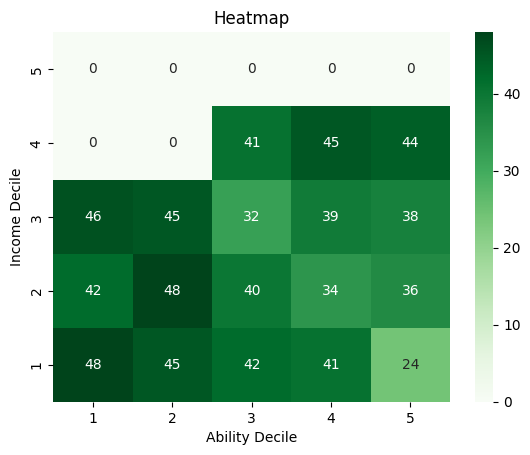

In [16]:
# This block show heat map of aid allocation in sum_util mode (Social welfare maximizing.)

df_totalexp = x_need_aid.groupby(['Income_decile', 'Ability_decile']).sum()

df_totalexp = df_totalexp.sort_values(by= 'Income_decile' , ascending= False)
# df_totalexp = df_totalexp.sort_values(by= 'Ability_decile' , ascending= True)

print(df_totalexp['aid'].sum())

heatmap_data = df_totalexp.pivot_table(index='Income_decile', columns='Ability_decile', values='aid')
heatmap_data = heatmap_data.sort_values(by= 'Income_decile' , ascending= False)

sns.heatmap(heatmap_data, annot=True, cmap='Greens')

# Set the plot title and labels
plt.title('Heatmap')
plt.xlabel('Ability Decile')
plt.ylabel('Income Decile')
# plt.yticks(rotation=180)
# Show the plot
plt.show()


In [17]:
# prepare data for assignment block(next block)
df1_ = df1[['util_quality_A' , 'util_quality_B' , 'util_quality_C' , 'util_quality_D' , 'util_quality_E']].rank(axis=1, method='max', ascending=False).astype(int).values.tolist()
df1_ranks = pd.DataFrame(df1_, columns = ['util_quality_A' , 'util_quality_B' , 'util_quality_C' , 'util_quality_D' , 'util_quality_E'])
df = pd.concat([df1_ranks, df1[['number' , 'Income_decile' , 'Ability_decile' , 'OUR_SAT_needAid', 'util_A', 'util_B','util_C','util_D','util_E']]], axis=1)
print(df.head())
df = df.sort_values('OUR_SAT_needAid' , ascending=False)

# print(x_need_aid['aid'].values)

   util_quality_A  util_quality_B  util_quality_C  util_quality_D  \
0               2               1               3               4   
1               2               1               3               4   
2               2               1               3               4   
3               2               1               3               4   
4               1               2               3               4   

   util_quality_E  number  Income_decile  Ability_decile  OUR_SAT_needAid  \
0               5       0              2               3         0.0+0.0j   
1               5       1              3               4         1.0+0.0j   
2               5       2              2               4         2.0+0.0j   
3               5       3              3               2         3.0+0.0j   
4               5       4              4               2         4.0+0.0j   

      util_A     util_B     util_C     util_D    util_E  
0  10.537290  10.665758  10.515276  10.467884  7.937445  
1  11.

In [18]:
# Assingment block
df.groupby(['util_quality_A', 'util_quality_B', 'util_quality_C', 'util_quality_D','util_quality_E']).count().reset_index()
A_cap = n/5
B_cap = n/5
C_cap = n/5
D_cap = n/5
E_cap = n/5
# df = df.dropna()
# Capacity of people attendance in every grade of uniersity.
A_students_people = []
B_students_people = []
C_students_people = []
D_students_people = []
E_students_people = []

###  Assighning people to universities based on their preference_list:
cols = ['util_quality_A', 'util_quality_B', 'util_quality_C', 'util_quality_D', 'util_quality_E']

print(df.shape[0])
for i, j in enumerate(range(df.shape[0])):
    num = int(df.iloc[j]['number'])
    preference_list = df.iloc[j][cols].tolist()
    
    for prefer in preference_list:
        if prefer== 1 and A_cap>=1:
            A_cap -=1
            A_students_people.append(num)
            level_tuition.append(level_tuition_A)
            break  
        elif prefer ==2 and B_cap>=1:
            B_cap -=1
            B_students_people.append(num)
            level_tuition.append(level_tuition_B)
            break        
        elif prefer ==3 and C_cap >=1:
            C_cap -=1
            C_students_people.append(num)
            level_tuition.append(level_tuition_C)
            break
        elif prefer ==4 and D_cap >=1:
            D_cap -=1
            D_students_people.append(num)
            level_tuition.append(level_tuition_D)
            break
        elif prefer ==5 and E_cap >=1:
            E_cap -=1
            E_students_people.append(num)
            level_tuition.append(level_tuition_E)
            break
            
            
#### Convert to DataFrame and change name to fit in merge condition.
A_stu_heat = df[df['number'].isin(A_students_people)]
B_stu_heat = df[df['number'].isin(B_students_people)]
C_stu_heat = df[df['number'].isin(C_students_people)]
D_stu_heat = df[df['number'].isin(D_students_people)]
E_stu_heat = df[df['number'].isin(E_students_people)]


# Build heatmap for college's attendance based on cross relation between Income and ability.

df_A = A_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_B = B_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_C = C_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_D = D_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_E = E_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()


dfi = pd.DataFrame({
        'Income_decile' : range(1 , 6)
        })
dfs = pd.DataFrame({
        'Ability_decile' : range(1 , 6)
        })
df_0 = dfi.merge(dfs , how = 'cross')


df_AA = df_0.merge(df_A , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_BB = df_0.merge(df_B , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_CC = df_0.merge(df_C , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_DD = df_0.merge(df_D , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_EE = df_0.merge(df_E , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)


dfA = df_AA.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

dfB = df_BB.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

dfC = df_CC.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

dfD = df_DD.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

dfE = df_EE.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)
###
dfA = 100*dfA/df.shape[0]
dfB = 100*dfB/df.shape[0]
dfC = 100*dfC/df.shape[0]
dfD = 100*dfD/df.shape[0]
dfE = 100*dfE/df.shape[0]

1000


In [19]:
### Save data for future plots, that we'll plot different income's aid.

A_stu_welafarecal = x_need_aid[x_need_aid['number'].isin(A_students_people)]
B_stu_welafarecal = x_need_aid[x_need_aid['number'].isin(B_students_people)]
C_stu_welafarecal = x_need_aid[x_need_aid['number'].isin(C_students_people)]
D_stu_welafarecal = x_need_aid[x_need_aid['number'].isin(D_students_people)]
E_stu_welafarecal = x_need_aid[x_need_aid['number'].isin(E_students_people)]

A_stu_welafarecal['total_util'] = np.log(A_stu_welafarecal['Income'] - A_stu_welafarecal['edu_inv1']+ A_stu_welafarecal['aid'] - A_stu_welafarecal['level_tuition_A']+1)+ A_stu_welafarecal['util_quality_A'] + beta*A_stu_welafarecal['Ability']
B_stu_welafarecal['total_util'] = np.log(B_stu_welafarecal['Income'] - B_stu_welafarecal['edu_inv1']+ B_stu_welafarecal['aid'] - B_stu_welafarecal['level_tuition_B']+1)+ B_stu_welafarecal['util_quality_B'] + beta*B_stu_welafarecal['Ability']
C_stu_welafarecal['total_util'] = np.log(C_stu_welafarecal['Income'] - C_stu_welafarecal['edu_inv1']+ C_stu_welafarecal['aid'] - C_stu_welafarecal['level_tuition_C']+1)+ C_stu_welafarecal['util_quality_C'] + beta*C_stu_welafarecal['Ability']
D_stu_welafarecal['total_util'] = np.log(D_stu_welafarecal['Income'] - D_stu_welafarecal['edu_inv1']+ D_stu_welafarecal['aid'] - D_stu_welafarecal['level_tuition_D']+1)+ D_stu_welafarecal['util_quality_D'] + beta*D_stu_welafarecal['Ability']
E_stu_welafarecal['total_util'] = np.log(E_stu_welafarecal['Income'] - E_stu_welafarecal['edu_inv1']+ E_stu_welafarecal['aid'] - E_stu_welafarecal['level_tuition_E']+1)+ E_stu_welafarecal['util_quality_E'] + beta*E_stu_welafarecal['Ability']

A_stu_welafarecal['cons'] = np.log(A_stu_welafarecal['Income'] - A_stu_welafarecal['edu_inv1']+ A_stu_welafarecal['aid'] - A_stu_welafarecal['level_tuition_A']+1)
B_stu_welafarecal['cons'] = np.log(B_stu_welafarecal['Income'] - B_stu_welafarecal['edu_inv1']+ B_stu_welafarecal['aid'] - B_stu_welafarecal['level_tuition_B']+1)
C_stu_welafarecal['cons'] = np.log(C_stu_welafarecal['Income'] - C_stu_welafarecal['edu_inv1']+ C_stu_welafarecal['aid'] - C_stu_welafarecal['level_tuition_C']+1)
D_stu_welafarecal['cons'] = np.log(D_stu_welafarecal['Income'] - D_stu_welafarecal['edu_inv1']+ D_stu_welafarecal['aid'] - D_stu_welafarecal['level_tuition_D']+1)
E_stu_welafarecal['cons'] = np.log(E_stu_welafarecal['Income'] - E_stu_welafarecal['edu_inv1']+ E_stu_welafarecal['aid'] - E_stu_welafarecal['level_tuition_E']+1)
welfare_cal = pd.concat([A_stu_welafarecal , B_stu_welafarecal , C_stu_welafarecal , D_stu_welafarecal , E_stu_welafarecal])
welfare_cal = welfare_cal.groupby(by='Income_decile').sum()


In [20]:
# Check remaining capacitites of unis.
A_cap, B_cap,C_cap, D_cap,E_cap

(0.0, 0.0, 0.0, 0.0, 0.0)

In [21]:

dff = df.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
dff = dff.rename(columns={"OUR_SAT_needAid": "count"})

In [22]:
dfW = dff.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'count')

dfW = 100*dfW/df.shape[0]

In [23]:
import math

def dist(x,y):
    x = x.values.flatten()
    y = y.values.flatten()
    
    S = 0
    for i in range(len(x)):
        S+=(x[i]-y[i])**2
        
    return math.sqrt(S)

In [24]:
O = dfW/5

d1 = dist(O, dfA)
d2 = dist(O, dfB)
d3 = dist(O, dfC)
d4 = dist(O, dfD)
d5 = dist(O, dfE)


In [25]:
# Define a function that can show us heatmap.
def draw_heat_map(df, label):
    plt.style.use("seaborn")

    #Plot the heatmap
    plt.figure(figsize=(5,5))
    heat_map = sns.heatmap(df, linewidth = 1 , annot = True , cmap="Greens")
    heat_map.set(xlabel='', ylabel='Income decile')
    heat_map.invert_yaxis()
    heat_map.tick_params(labeltop=True, labelbottom=False, top=False)
    plt.title(f"Ability decile {label}")
#     plt.savefig('Geometry Aid consequences A_stu_heat.png', dpi=300 , bbox_inches='tight')

    plt.show()

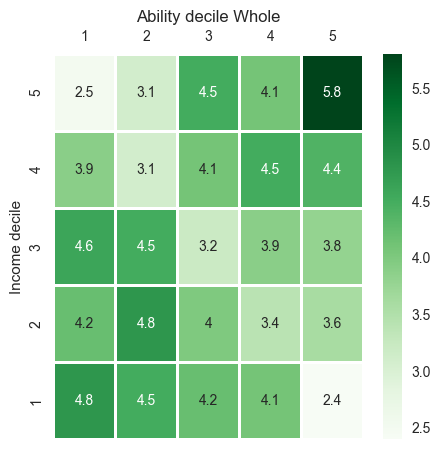

In [26]:
# Total population heatmap
draw_heat_map(dfW, "Whole")

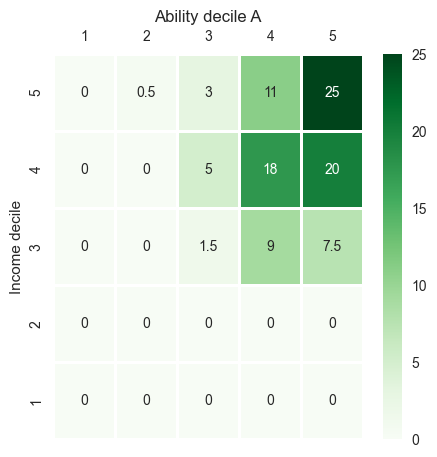

In [27]:
# First level population heatmap.
draw_heat_map(dfA*5, "A")

Aid Allocation for differnt income deciles: [27.77777777777778, 27.77777777777778, 27.77777777777778, 18.055555555555557, 0.0]


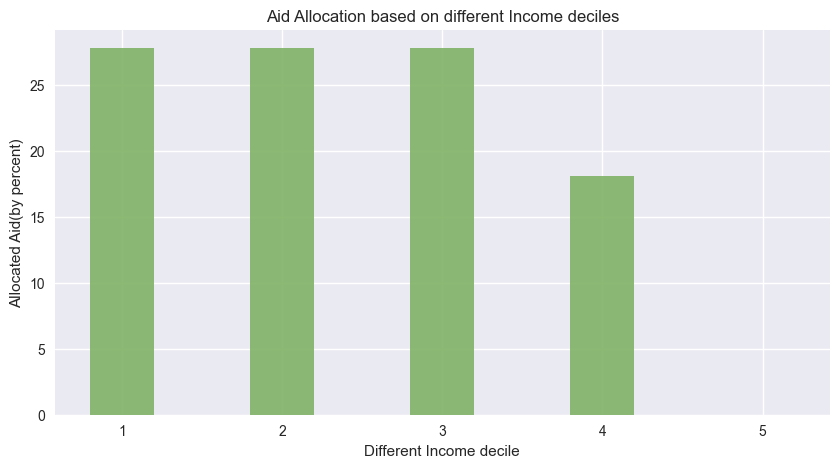

In [28]:
A_stu_final = pd.DataFrame(A_students_people , columns=['number'])
B_stu_final = pd.DataFrame(B_students_people , columns=['number'])
C_stu_final = pd.DataFrame(C_students_people , columns=['number'])
D_stu_final = pd.DataFrame(D_students_people , columns=['number'])
E_stu_final = pd.DataFrame(E_students_people , columns=['number'])

A_stu_final = pd.merge(A_stu_final , x_need_aid , on= 'number')
B_stu_final = pd.merge(B_stu_final , x_need_aid , on= 'number')
C_stu_final = pd.merge(C_stu_final , x_need_aid , on= 'number')
D_stu_final = pd.merge(D_stu_final , x_need_aid , on= 'number')
E_stu_final = pd.merge(E_stu_final , x_need_aid , on= 'number')

total_util = A_stu_final['util_quality_A'].sum() + B_stu_final['util_quality_B'].sum() + C_stu_final['util_quality_C'].sum() + D_stu_final['util_quality_D'].sum() + E_stu_final['util_quality_E'].sum()

# Educational Aid allocation for every different income decile.

welfare_inv = welfare_inv.groupby('Income_decile').sum()

income_list = welfare_inv.index.to_list()

Aid_list = welfare_inv['aid'].to_list() 
Aid_list = [100*i/720  for i in Aid_list]
print('Aid Allocation for differnt income deciles:',Aid_list)

fig = plt.figure(figsize = (10, 5))

color = (0.5, # redness
         0.7, # greenness
         0.4, # blueness
         0.9 # transparency
         ) 
# creating the bar plot
plt.bar(income_list, Aid_list, color =color, 
        width = 0.4)
 
plt.xlabel("Different Income decile")
plt.ylabel("Allocated Aid(by percent)")
plt.title("Aid Allocation based on different Income deciles")
plt.show()

In [29]:
#_util_var = A_stu_final['util_quality_A'].var()+ B_stu_final['util_quality_B'].var() + C_stu_final['util_quality_C'].var() + D_stu_final['util_quality_D'].var() + E_stu_final['util_quality_E'].var()

#_util_var_list = []

A_stu_final = A_stu_final['util_quality_A'].to_list()
B_stu_final = B_stu_final['util_quality_B'].to_list()
C_stu_final = C_stu_final['util_quality_C'].to_list()
D_stu_final = D_stu_final['util_quality_D'].to_list()
E_stu_final = E_stu_final['util_quality_E'].to_list()

A_stu_final.extend(B_stu_final)
A_stu_final.extend(C_stu_final)
A_stu_final.extend(D_stu_final)
A_stu_final.extend(E_stu_final)


In [30]:

variannce_socialwelfare = np.var(A_stu_final)


In [31]:
variannce_socialwelfare

2.5491156585620587

In [32]:
total_util

10509.61547715125

### Second Policy: Minimaizer of dispersion of utility.

In [33]:
### Sim util allocation

min_aid = "1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0"
min_aid = list(map(int, min_aid.split(" ")))

max_aid = "1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1"
max_aid = list(map(int, max_aid.split(" ")))





# x_need_aid_disper['aid'] = [random.random()*45000 for i in range(x_need_aid_disper.shape[0])]
x_need_aid_disper['aid'] = x_need_aid_disper[['Income_decile','Ability_decile']].apply(lambda x: cal_aid(x[0], x[1], min_aid)*1, axis=1)

b_bar = 10
zeta = 0.41
OUR_SAT_needAid = []
for i,j in enumerate(x_need_aid_disper['Ability']):
    if j>= b_bar: OUR_SAT_needAid.append(b_bar+ (j-b_bar)**(zeta) * (x_need_aid_disper.iloc[i]['edu_inv1']**(1-zeta)))
    else:OUR_SAT_needAid.append(i)

x_need_aid_disper['OUR_SAT_needAid'] =OUR_SAT_needAid
# x_need_aid_disper['OUR_SAT'] =OUR_SAT_needAid



x_need_aid_disper['level_tuition_A'] = level_tuition_A
x_need_aid_disper['level_tuition_B'] = level_tuition_B
x_need_aid_disper['level_tuition_C'] = level_tuition_C
x_need_aid_disper['level_tuition_D'] = level_tuition_D
x_need_aid_disper['level_tuition_E'] = level_tuition_E


for label in quality_utility.keys():
    noise = np.random.gumbel(mu, sigma , x_need_aid_disper.shape[0])
    x_need_aid_disper[f'util_quality_{label}'] = (np.log(x_need_aid_disper['Income'] - x_need_aid_disper['edu_inv1'] - x_need_aid_disper[f'level_tuition_{label}'] + x_need_aid_disper['aid']+1)+ np.log(quality_utility[label]+1) + beta * np.log(x_need_aid_disper['Ability']+1)) + noise




In [34]:
# This number column is name of people.
x_need_aid_disper['number'] = [i for i , j in x_need_aid_disper.iterrows()]

In [35]:
# prepare data to show heatmap
df_dispa1 = x_need_aid_disper[['number' , 'Income_decile' , 'Ability_decile' , 'OUR_SAT_needAid', 'util_quality_A' , 'util_quality_B' , 'util_quality_C' , 'util_quality_D' , 'util_quality_E']]
# print(df_dispa1.head())
# print("---"*10)
df_dispa1['util_A'] = df_dispa1['util_quality_A']
df_dispa1['util_B'] = df_dispa1['util_quality_B']
df_dispa1['util_C'] = df_dispa1['util_quality_C']
df_dispa1['util_D'] = df_dispa1['util_quality_D']
df_dispa1['util_E'] = df_dispa1['util_quality_E']



df_dispa1_ = df_dispa1[['util_quality_A' , 'util_quality_B' , 'util_quality_C' , 'util_quality_D' , 'util_quality_E']].rank(axis=1, method='max', ascending=False).astype(int).values.tolist()
df_dispa1_ranks = pd.DataFrame(df_dispa1_, columns = ['util_quality_A' , 'util_quality_B' , 'util_quality_C' , 'util_quality_D' , 'util_quality_E'])
df_dispa = pd.concat([df_dispa1_ranks, df_dispa1[['number' , 'Income_decile' , 'Ability_decile' , 'OUR_SAT_needAid', 'util_A', 'util_B','util_C','util_D','util_E']]], axis=1)
print(df_dispa.head())
df_dispa = df_dispa.sort_values('OUR_SAT_needAid' , ascending=False)





df_dispa.groupby(['util_quality_A', 'util_quality_B', 'util_quality_C', 'util_quality_D','util_quality_E']).count().reset_index()
## based on our assumptions,college's quality distributed equally.
A_cap = n/5
B_cap = n/5  
C_cap = n/5
D_cap = n/5
E_cap = n/5
# df_dispa = df_dispa.dropna()
# Capacity of people attendance in every grade of uniersity.
A_students_people = []
B_students_people = []
C_students_people = []
D_students_people = []
E_students_people = []

cols = ['util_quality_A', 'util_quality_B', 'util_quality_C', 'util_quality_D', 'util_quality_E']
###  Assighning people to universities based on their preference_list: 

print(df_dispa.shape[0])
for i, j in enumerate(range(df_dispa.shape[0])):
    num = int(df_dispa.iloc[j]['number'])
    preference_list = df_dispa.iloc[j][cols].tolist()
    
    for prefer in preference_list:
        if prefer== 1 and A_cap>=1:
            A_cap -=1
            A_students_people.append(num)
            level_tuition.append(level_tuition_A)
            break  
        elif prefer ==2 and B_cap>=1:
            B_cap -=1
            B_students_people.append(num)
            level_tuition.append(level_tuition_B)
            break        
        elif prefer ==3 and C_cap >=1:
            C_cap -=1
            C_students_people.append(num)
            level_tuition.append(level_tuition_C)
            break
        elif prefer ==4 and D_cap >=1:
            D_cap -=1
            D_students_people.append(num)
            level_tuition.append(level_tuition_D)
            break
        elif prefer ==5 and E_cap >=1:
            E_cap -=1
            E_students_people.append(num)
            level_tuition.append(level_tuition_E)
            break
            
            
#### Convert to DataFrame and change name to fit in merge condition.
A_stu_heat = df_dispa[df_dispa['number'].isin(A_students_people)]
B_stu_heat = df_dispa[df_dispa['number'].isin(B_students_people)]
C_stu_heat = df_dispa[df_dispa['number'].isin(C_students_people)]
D_stu_heat = df_dispa[df_dispa['number'].isin(D_students_people)]
E_stu_heat = df_dispa[df_dispa['number'].isin(E_students_people)]


# Build heatmap for cross relation between Income and ability.

df_dispa_A = A_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_dispa_B = B_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_dispa_C = C_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_dispa_D = D_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_dispa_E = E_stu_heat.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()


df_dispai = pd.DataFrame({
        'Income_decile' : range(1 , 6)
        })
df_dispas = pd.DataFrame({
        'Ability_decile' : range(1 , 6)
        })
df_dispa_0 = df_dispai.merge(df_dispas , how = 'cross')


df_dispa_AA = df_dispa_0.merge(df_dispa_A , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_dispa_BB = df_dispa_0.merge(df_dispa_B , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_dispa_CC = df_dispa_0.merge(df_dispa_C , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_dispa_DD = df_dispa_0.merge(df_dispa_D , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)
df_dispa_EE = df_dispa_0.merge(df_dispa_E , how = 'left' , on = ['Income_decile' , 'Ability_decile']).fillna(0)


df_dispaA = df_dispa_AA.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

df_dispaB = df_dispa_BB.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

df_dispaC = df_dispa_CC.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

df_dispaD = df_dispa_DD.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)

df_dispaE = df_dispa_EE.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'OUR_SAT_needAid').astype(int)
###
df_dispaA = 100*df_dispaA/df_dispa.shape[0]
df_dispaB = 100*df_dispaB/df_dispa.shape[0]
df_dispaC = 100*df_dispaC/df_dispa.shape[0]
df_dispaD = 100*df_dispaD/df_dispa.shape[0]
df_dispaE = 100*df_dispaE/df_dispa.shape[0]




df_dispaf = df_dispa.groupby(["Income_decile" , "Ability_decile"])['OUR_SAT_needAid'].count().reset_index()
df_dispaf = df_dispaf.rename(columns={"OUR_SAT_needAid": "count"})





df_dispaW = df_dispaf.pivot(index = 'Income_decile' ,
               columns = 'Ability_decile' ,
               values = 'count')

df_dispaW = 100*df_dispaW/df_dispa.shape[0]




def dist(x,y):
    x = x.values.flatten()
    y = y.values.flatten()
    
    S = 0
    for i in range(len(x)):
        S+=(x[i]-y[i])**2
        
    return math.sqrt(S)



O = df_dispaW/5
# print(dist(df_dispaW, df_dispaW),dist(df_dispaA, df_dispaW),dist(df_dispaB, df_dispaW),dist(df_dispaC, df_dispaW),dist(df_dispaD, df_dispaW),dist(df_dispaE, df_dispaW))
# print(dist(O, O),dist(df_dispaA, O),dist(df_dispaB, O),dist(df_dispaC, O),dist(df_dispaD, O),dist(df_dispaE, O))
# print(dist(df_dispaW, df_dispaW)+dist(df_dispaA, df_dispaW)+dist(df_dispaB, df_dispaW)+dist(df_dispaC, df_dispaW)+dist(df_dispaD, df_dispaW)+dist(df_dispaE, df_dispaW))
# print(dist(O, O)+dist(df_dispaA, O)+dist(df_dispaB, O)+dist(df_dispaC, O)+dist(df_dispaD, O)+dist(df_dispaE, O))

d1 = dist(O, df_dispaA)
d2 = dist(O, df_dispaB)
d3 = dist(O, df_dispaC)
d4 = dist(O, df_dispaD)
d5 = dist(O, df_dispaE)

# print(d1+d2+d3+d4+d5)



def draw_heat_map(df_dispa, label):
    plt.style.use("seaborn")

    #Plot the heatmap
    plt.figure(figsize=(5,5))
    heat_map = sns.heatmap(df_dispa, linewidth = 1 , annot = True , cmap="Greens")
    heat_map.set(xlabel='', ylabel='Income decile')
    heat_map.invert_yaxis()
    heat_map.tick_params(labeltop=True, labelbottom=False, top=False)
    plt.title(f"Ability decile {label}")
    # plt.savefig(f'{df_dispa}.png', dpi=300 , bbox_inches='tight')

    plt.show()




   util_quality_A  util_quality_B  util_quality_C  util_quality_D  \
0               2               1               3               4   
1               2               1               3               4   
2               2               1               3               4   
3               1               2               3               4   
4               1               2               3               4   

   util_quality_E  number  Income_decile  Ability_decile  OUR_SAT_needAid  \
0               5       0              2               3        10.626952   
1               5       1              3               4        10.942720   
2               5       2              2               4        10.912363   
3               5       3              3               2        10.788989   
4               5       4              4               2        10.878158   

      util_A     util_B     util_C     util_D    util_E  
0  10.521326  10.673471  10.506959  10.482084  7.942391  
1  11.

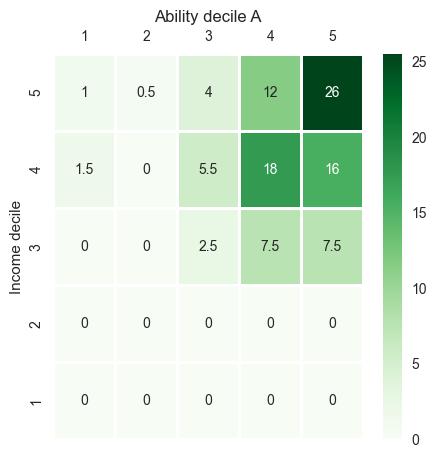

In [36]:
### A level university attendance pattern.
draw_heat_map(df_dispaA*5, "A")

In [37]:
A_stu_final_disper = pd.DataFrame(A_students_people , columns=['number'])
B_stu_final_disper = pd.DataFrame(B_students_people , columns=['number'])
C_stu_final_disper = pd.DataFrame(C_students_people , columns=['number'])
D_stu_final_disper = pd.DataFrame(D_students_people , columns=['number'])
E_stu_final_disper = pd.DataFrame(E_students_people , columns=['number'])

A_stu_final_disper = pd.merge(A_stu_final_disper , x_need_aid_disper , on= 'number')
B_stu_final_disper = pd.merge(B_stu_final_disper , x_need_aid_disper , on= 'number')
C_stu_final_disper = pd.merge(C_stu_final_disper , x_need_aid_disper , on= 'number')
D_stu_final_disper = pd.merge(D_stu_final_disper , x_need_aid_disper , on= 'number')
E_stu_final_disper = pd.merge(E_stu_final_disper , x_need_aid_disper , on= 'number')

In [38]:
total_util_disper = A_stu_final_disper['util_quality_A'].sum() + B_stu_final_disper['util_quality_B'].sum() + C_stu_final_disper['util_quality_C'].sum() + D_stu_final_disper['util_quality_D'].sum() + E_stu_final_disper['util_quality_E'].sum()

In [39]:
A_stu_final_disperutil = pd.DataFrame(A_students_people , columns=['number'])
B_stu_final_disperutil = pd.DataFrame(B_students_people , columns=['number'])
C_stu_final_disperutil = pd.DataFrame(C_students_people , columns=['number'])
D_stu_final_disperutil = pd.DataFrame(D_students_people , columns=['number'])
E_stu_final_disperutil = pd.DataFrame(E_students_people , columns=['number'])

A_stu_final_disperutil = pd.merge(A_stu_final_disperutil , x_need_aid_disper , on= 'number')
B_stu_final_disperutil = pd.merge(B_stu_final_disperutil , x_need_aid_disper , on= 'number')
C_stu_final_disperutil = pd.merge(C_stu_final_disperutil , x_need_aid_disper , on= 'number')
D_stu_final_disperutil = pd.merge(D_stu_final_disperutil , x_need_aid_disper , on= 'number')
E_stu_final_disperutil = pd.merge(E_stu_final_disperutil , x_need_aid_disper , on= 'number')

total_util_disper = A_stu_final_disperutil['util_quality_A'].sum() + B_stu_final_disperutil['util_quality_B'].sum() + C_stu_final_disperutil['util_quality_C'].sum() + D_stu_final_disperutil['util_quality_D'].sum() + E_stu_final_disperutil['util_quality_E'].sum()

# Educational Aid allocation for every different income decile.


Aid Allocation for differnt income deciles: [27.397260273972602, 27.397260273972602, 27.397260273972602, 17.80821917808219, 0.0]


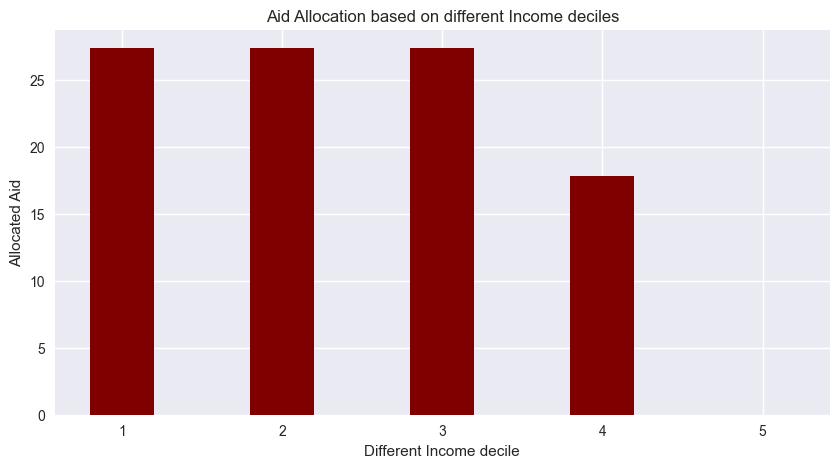

In [40]:

disperutil_inv = disperutil_inv.groupby('Income_decile').sum()

income_list_disper = disperutil_inv.index.to_list()

Aid_list_disperutil = disperutil_inv['aid'].to_list() 
Aid_list_disperutil = [100*i/730  for i in Aid_list_disperutil]

print('Aid Allocation for differnt income deciles:',Aid_list_disperutil)

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(income_list_disper, Aid_list_disperutil, color ='maroon', 
        width = 0.4)
 
plt.xlabel("Different Income decile")
plt.ylabel("Allocated Aid")
plt.title("Aid Allocation based on different Income deciles")
plt.show()

In [41]:
A_stu_utildispersion = x_need_aid_disper[x_need_aid_disper['number'].isin(A_students_people)]
B_stu_utildispersion = x_need_aid_disper[x_need_aid_disper['number'].isin(B_students_people)]
C_stu_utildispersion = x_need_aid_disper[x_need_aid_disper['number'].isin(C_students_people)]
D_stu_utildispersion = x_need_aid_disper[x_need_aid_disper['number'].isin(D_students_people)]
E_stu_utildispersion = x_need_aid_disper[x_need_aid_disper['number'].isin(E_students_people)]

A_stu_utildispersion['total_util'] = np.log(A_stu_utildispersion['Income'] - A_stu_utildispersion['edu_inv1']+ A_stu_utildispersion['aid'] - A_stu_utildispersion['level_tuition_A']+1)+ A_stu_utildispersion['util_quality_A'] + beta*A_stu_utildispersion['Ability']
B_stu_utildispersion['total_util'] = np.log(B_stu_utildispersion['Income'] - B_stu_utildispersion['edu_inv1']+ B_stu_utildispersion['aid'] - B_stu_utildispersion['level_tuition_B']+1)+ B_stu_utildispersion['util_quality_B'] + beta*B_stu_utildispersion['Ability']
C_stu_utildispersion['total_util'] = np.log(C_stu_utildispersion['Income'] - C_stu_utildispersion['edu_inv1']+ C_stu_utildispersion['aid'] - C_stu_utildispersion['level_tuition_C']+1)+ C_stu_utildispersion['util_quality_C'] + beta*C_stu_utildispersion['Ability']
D_stu_utildispersion['total_util'] = np.log(D_stu_utildispersion['Income'] - D_stu_utildispersion['edu_inv1']+ D_stu_utildispersion['aid'] - D_stu_utildispersion['level_tuition_D']+1)+ D_stu_utildispersion['util_quality_D'] + beta*D_stu_utildispersion['Ability']
E_stu_utildispersion['total_util'] = np.log(E_stu_utildispersion['Income'] - E_stu_utildispersion['edu_inv1']+ E_stu_utildispersion['aid'] - E_stu_utildispersion['level_tuition_E']+1)+ E_stu_utildispersion['util_quality_E'] + beta*E_stu_utildispersion['Ability']

A_stu_utildispersion['cons'] = np.log(A_stu_utildispersion['Income'] - A_stu_utildispersion['edu_inv1']+ A_stu_utildispersion['aid'] - A_stu_utildispersion['level_tuition_A']+1)
B_stu_utildispersion['cons'] = np.log(B_stu_utildispersion['Income'] - B_stu_utildispersion['edu_inv1']+ B_stu_utildispersion['aid'] - B_stu_utildispersion['level_tuition_B']+1)
C_stu_utildispersion['cons'] = np.log(C_stu_utildispersion['Income'] - C_stu_utildispersion['edu_inv1']+ C_stu_utildispersion['aid'] - C_stu_utildispersion['level_tuition_C']+1)
D_stu_utildispersion['cons'] = np.log(D_stu_utildispersion['Income'] - D_stu_utildispersion['edu_inv1']+ D_stu_utildispersion['aid'] - D_stu_utildispersion['level_tuition_D']+1)
E_stu_utildispersion['cons'] = np.log(E_stu_utildispersion['Income'] - E_stu_utildispersion['edu_inv1']+ E_stu_utildispersion['aid'] - E_stu_utildispersion['level_tuition_E']+1)
disperutil_cal = pd.concat([A_stu_utildispersion , B_stu_utildispersion , C_stu_utildispersion , D_stu_utildispersion , E_stu_utildispersion])
disperutil_cal = disperutil_cal.groupby(by='Income_decile').sum()
disperutil_cal


,Ability,Income,edu_inv1,Ability_decile,aid,OUR_SAT_needAid,level_tuition_A,level_tuition_B,level_tuition_C,level_tuition_D,level_tuition_E,util_quality_A,util_quality_B,util_quality_C,util_quality_D,util_quality_E,number,total_util,cons
Income_decile,,,,,,,,,,,,,,,,,,,
1,3091.453668,153.859381,12.308750,548,200,2700.979899,320.0,160.0,140.0,100.0,0,1858.129173,1980.466865,1956.380031,1959.615183,1474.933799,100152,4257.159683,183.315438
2,3129.330349,737.635273,36.881764,574,200,3178.038256,320.0,160.0,140.0,100.0,0,2162.089917,2176.759093,2145.338669,2135.812442,1625.224966,99880,4906.203871,318.433759
3,3146.776729,1185.141813,47.405673,578,200,2170.606116,320.0,160.0,140.0,100.0,0,2253.530598,2254.572999,2221.970267,2209.551339,1693.178169,98504,5112.447696,384.793330
4,3211.388232,1654.735779,49.642073,624,70,3403.774877,320.0,160.0,140.0,100.0,0,2305.339251,2301.639373,2268.243018,2255.154900,1735.820714,98275,5264.270485,422.763481
5,3299.613517,2365.932279,47.318646,676,25,3816.372419,320.0,160.0,140.0,100.0,0,2379.452616,2369.922751,2335.926715,2321.584565,1799.951378,102689,5466.062319,489.293585


In [42]:
total_util_zerostate = 9939.300521688865

In [43]:
print('Social welafare for different income decile in maximaizing social welfare is', total_util)
print('Social welafare for different income decile in minimaizing dispersion of utility is', total_util_disper)
print('Social welafare for different income decile in total util zero is', total_util_zerostate)


Social welafare for different income decile in maximaizing social welfare is 10509.61547715125
Social welafare for different income decile in minimaizing dispersion of utility is 10504.69446625732
Social welafare for different income decile in total util zero is 9939.300521688865


### Consumption for different decile

In [44]:
zerostate_utility = [82.3469971416435,
 299.04637915975275,
 379.1056537714724,
 439.35780385687787,
 504.6039861950231] # We copied this consumption list from first code file.

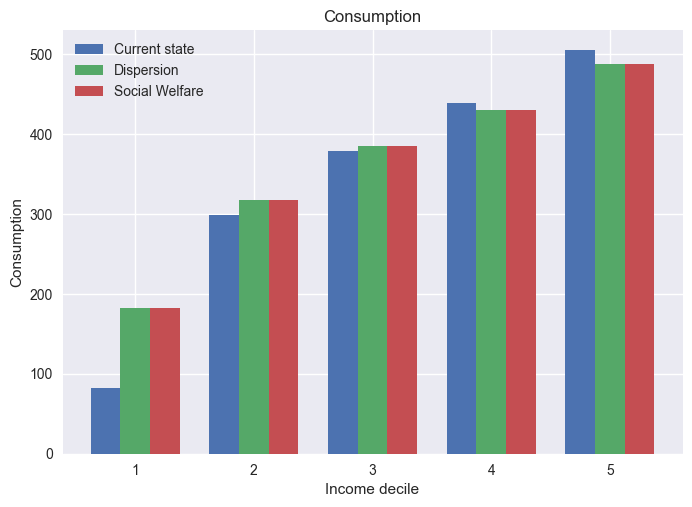

In [45]:
#  consumption bar plot.

# Define the lists
x = [1, 2, 3, 4, 5]  # x-axis values
zerostate_Consumption = zerostate_utility  
dispersion_Consumption = welfare_cal['cons'].to_list()
welfare_Consumption = welfare_cal['cons'].to_list()  

bar_width = 0.25

bar_positions1 = np.arange(len(x))
bar_positions2 = [x + bar_width for x in bar_positions1]
bar_positions3 = [x + 2 * bar_width for x in bar_positions1]

plt.bar(bar_positions1, zerostate_Consumption  , width=bar_width, label='Current state')
plt.bar(bar_positions2, dispersion_Consumption , width=bar_width, label='Dispersion')
plt.bar(bar_positions3, welfare_Consumption    , width=bar_width, label='Social Welfare')

plt.xlabel('Income decile')
plt.ylabel('Consumption')
plt.title('Consumption')

plt.xticks(bar_positions2, x)

plt.legend()

plt.show()


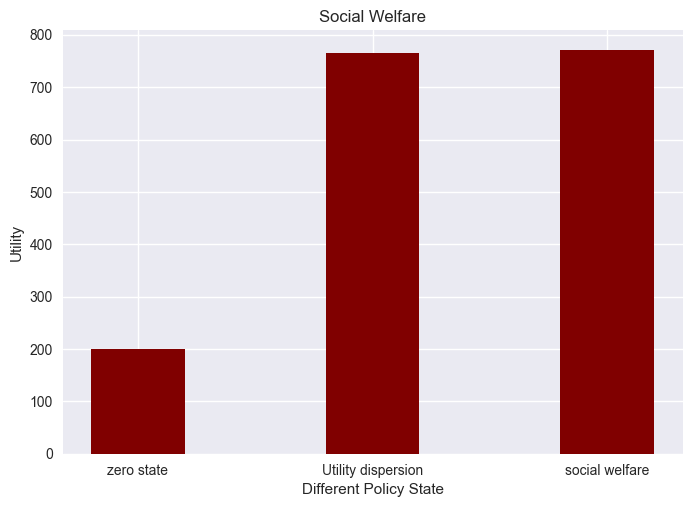

In [46]:
import matplotlib.pyplot as plt

name_list = ['zero state', 'Utility dispersion', 'social welfare']
y = [total_util_zerostate, total_util_disper, total_util]

scale = total_util_zerostate -200  # I scale all amount by 'scale' value.
scaled_y = [i-scale for i in y ]


plt.bar(name_list, scaled_y, color='maroon', width=0.4)

plt.xlabel("Different Policy State")
plt.ylabel("Utility")
plt.title("Social Welfare")

plt.show()
